<a href="https://colab.research.google.com/github/skumarudel/DS_Physicists/blob/master/Lecture3-Statistics/HypothesisTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding the sales of a particular product using Web engagement as a proxy

In [73]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
from sklearn.utils import resample

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Files required for analysis

In [74]:
path_to_data = 'https://raw.githubusercontent.com/skumarudel/DS_Physicists/master/Lecture3-Statistics/datafiles/'

WEB_PAGE_DATA_CSV = path_to_data + 'web_page_data.csv'
FOUR_SESSIONS_CSV =  path_to_data + 'four_sessions.csv'
CLICK_RATE_CSV = path_to_data + 'click_rates.csv'
IMANISHI_CSV = path_to_data + 'imanishi_data.csv'

In [75]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 60 * session_times.Time  # convert to seconds


In [76]:
session_times.head()



,Page,Time
0,Page A,12.6
1,Page B,151.8
2,Page A,21.0
3,Page B,42.6
4,Page A,40.2


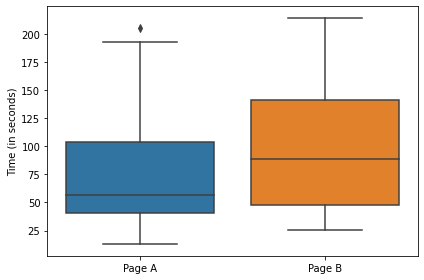

In [77]:
ax = sns.boxplot(x="Page", y="Time", data=session_times)
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [78]:
len(session_times[session_times.Page == 'Page B'])

15

In [79]:
df_time = session_times.groupby(['Page']).mean().reset_index().rename(columns={'Time': 'Mean_Time'})
df_time

,Page,Mean_Time
0,Page A,75.8
1,Page B,97.2


In [80]:
observed_diff = df_time.Mean_Time.iloc[1] - df_time.Mean_Time.iloc[0]
print("Average time difference spend by customers on PageB vs PageA = {:.1f} seconds".format(observed_diff))

Average time difference spend by customers on PageB vs PageA = 21.4 seconds


In [81]:
def difference_of_means(x,y):
    return np.mean(y) -  np.mean(x)

def test_null(df, iters = 1000):
  groupA = len(df[df.Page == "Page A"])
  groupA = len(df[df.Page == "Page B"])
  time = df.Time.to_numpy()
  means_diff = np.zeros(iters)
  for i in range(iters):
      resample_data = resample(time)
      xx, yy = resample_data[:groupA], resample_data[groupA:]
      means_diff[i] = difference_of_means(xx,yy)
        
        
  return means_diff
    

The p-value for these samples is 0.12
We can not reject the null hypothesis i.e Page B is not statistically different from Page A


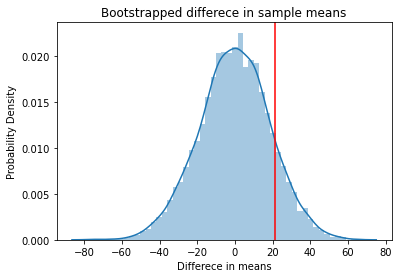

In [87]:
np.random.seed(5)
diff_of_mean = test_null(session_times, iters=5000)
sns.distplot(diff_of_mean)
    
plt.title('Bootstrapped differece in sample means')
plt.xlabel('Differece in means')
plt.ylabel('Probability Density')
plt.axvline(observed_diff, color='red')
#plt.legend()
p_value = np.sum(diff_of_mean >= observed_diff) / len(diff_of_mean)
print("The p-value for these samples is {:.2g}".format(p_value))

if p_value < 0.05:
    print('We can reject the null hypothesis that Page B is better than Page A in terms of retenion of customers')
else:
    print('We can not reject the null hypothesis i.e Page B is not statistically different from Page A')



In [83]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == 'Page A'].Time, 
    session_times[session_times.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')
print(f'p-value: {pvalue:.4f}')

p-value: 0.1408


## ANOVA

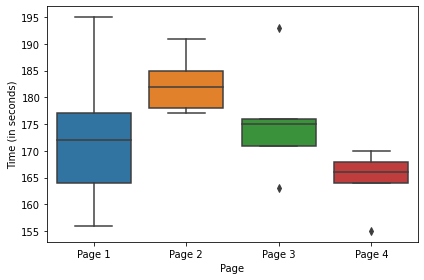

In [90]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = sns.boxplot(x='Page', y='Time',data=four_sessions)
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [91]:
four_sessions.head(10)

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172
5,Page 2,191
6,Page 3,193
7,Page 4,166
8,Page 1,177
9,Page 2,182


In [97]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)
# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))




Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
23.746666666666666


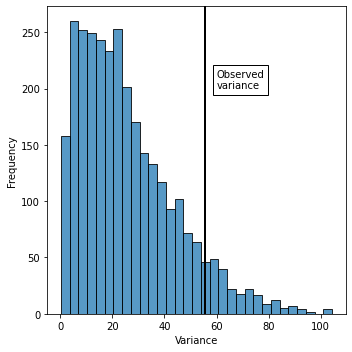

In [117]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]

p_value_var = np.sum(perm_variance >= observed_variance) / len(perm_variance)
#print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(perm_variance)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [107]:
p_value_var

0.08366666666666667

In [114]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)


            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [115]:
res = stats.f_oneway(four_sessions[four_sessions.Page == 'Page 1'].Time, 
                     four_sessions[four_sessions.Page == 'Page 2'].Time,
                     four_sessions[four_sessions.Page == 'Page 3'].Time,
                     four_sessions[four_sessions.Page == 'Page 4'].Time)
print(f'F-Statistic: {res.statistic / 2:.4f}')
print(f'p-value: {res.pvalue / 2:.4f}')

F-Statistic: 1.3699
p-value: 0.0388
